In [1]:
%pip install tf_keras_vis tflite-support-nightly
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 42.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.0 MB 44.8 MB/s 
     |████████████████████████████████| 213 kB 59.2 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


# Create your dataset

In [2]:
def create_dataframe_from_directories(path):
    data = []
    labels = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        label = label_dir.split("_")
        labels.append(label)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label[0], label[1]])
        
    return (pd.DataFrame(data, columns = ["path", "unit", "type"]), labels)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PREFIX = '/content/drive/MyDrive/ARN-PW5-datasets'

Mounted at /content/drive


In [4]:
df_train, labels = create_dataframe_from_directories(DRIVE_PREFIX + "/cropped/dataset_train")
df_test, labels = create_dataframe_from_directories(DRIVE_PREFIX + "/cropped/dataset_test")
dataframe = pd.concat([df_train, df_test])
labels

[['3B', 'fille'],
 ['3B', 'gars'],
 ['1B', 'fille'],
 ['4B', 'resp'],
 ['2B', 'fille'],
 ['1B', 'gars'],
 ['2B', 'gars']]

### Binarize labels
#### Multilabel from directory structure

In [5]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

#### Label encoders for multiple labels

In [6]:
UNIT_CLASSES = 4
TYPE_CLASSES = 3

unit_encoder = LabelEncoder()
unit_encoder.fit(df_train["unit"])

type_encoder = LabelEncoder()
type_encoder.fit(df_train["type"])

for (i, label) in enumerate(unit_encoder.classes_):
	print("{}. {} -> {}".format(i + 1, label, unit_encoder.transform([label])[0]))
 
print()
for (i, label) in enumerate(type_encoder.classes_):
	print("{}. {} -> {}".format(i + 1, label, type_encoder.transform([label])[0]))

1. 1B -> 0
2. 2B -> 1
3. 3B -> 2
4. 4B -> 3

1. fille -> 0
2. gars -> 1
3. resp -> 2


### Display some images of your dataset

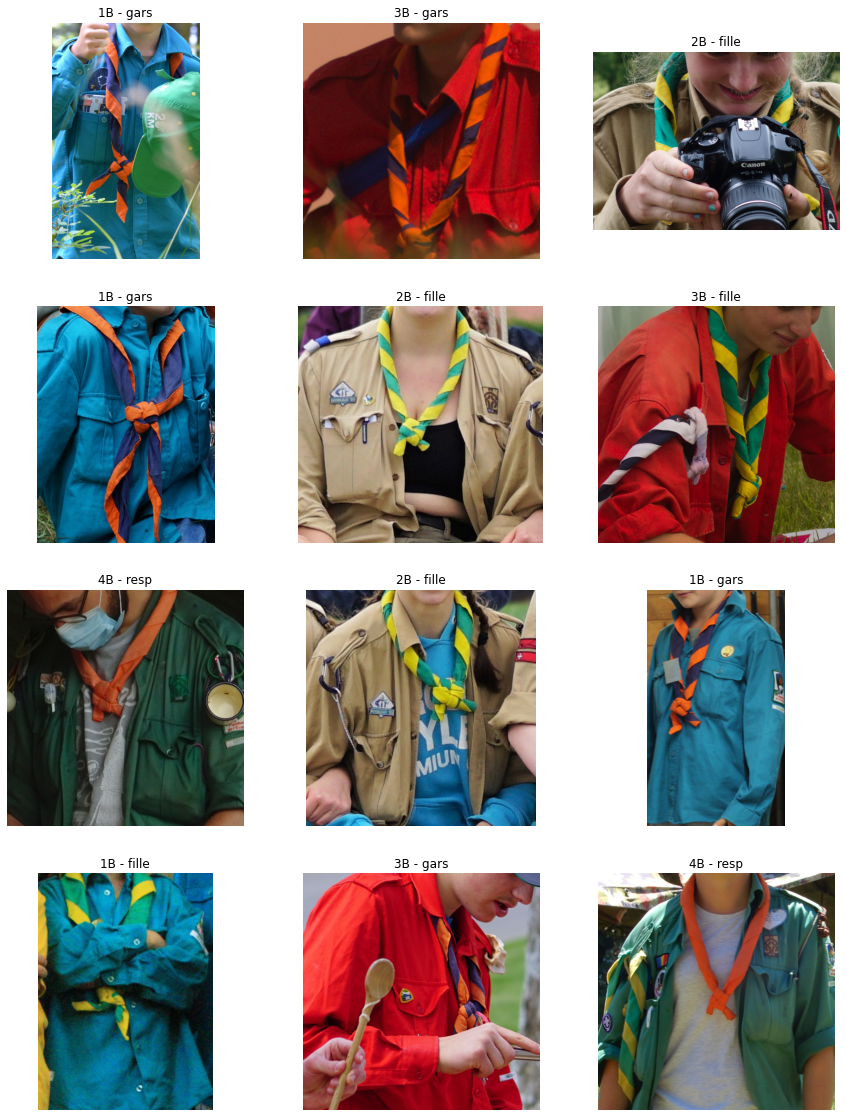

In [7]:
plt.figure(figsize=(15, 20))

i = 0
for _, rowdata in df_train.sample(frac=1).head(12).iterrows():
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(f'{rowdata.unit} - {rowdata.type}')
    plt.axis("off")
    i += 1

# Explore your dataset

In [8]:
def plot_bar(serie, label, color="tab:blue"):
   serie.value_counts().sort_index().plot.bar(title=f"Images per {label}", xlabel=label, ylabel="# of images", rot=45, color=color)
   print(f"{label}:\n{serie.value_counts().sort_index()}\n")

Unit:
1B    49
2B    40
3B    40
4B    38
Name: unit, dtype: int64

Types:
fille    62
gars     67
resp     38
Name: type, dtype: int64

Group:
1B - fille    22
1B - gars     27
2B - fille    22
2B - gars     18
3B - fille    18
3B - gars     22
4B - resp     38
dtype: int64



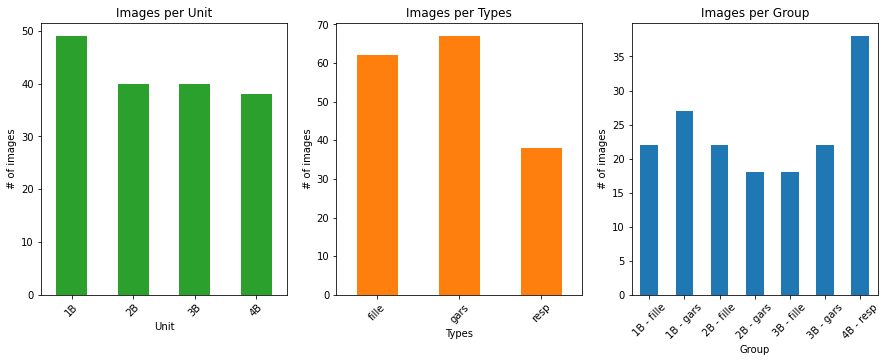

In [9]:
units = dataframe.unit.value_counts().sort_index()
types = dataframe.type.value_counts()
unit_types = dataframe.groupby(["unit", "type"]).size()



plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1)
plot_bar(serie=dataframe.unit, label="Unit", color="tab:green")
ax = plt.subplot(1, 3, 2)
plot_bar(serie=dataframe.type, label="Types", color="tab:orange")
ax = plt.subplot(1, 3, 3)
plot_bar(dataframe["unit"] + " - " + dataframe["type"], "Group")

# Preprocessing steps

In [10]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation
)

from tensorflow.keras import Sequential
from tensorflow import keras

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH),
    Rescaling(1. / 255)
])

image_augmentations = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    RandomRotation(0.15),
    RandomTranslation(0.1, 0.1)
    ])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img, training=True) for img in images
    ])

def augment_batch_images(images, labels, rate):
   aug_images = augment_images(images)
   aug_labels = labels
   for i in range(1, rate):
      new_images = augment_images(images)
      aug_images = np.concatenate([aug_images, new_images])
      aug_labels = np.concatenate([aug_labels, labels])
   return aug_images, aug_labels

## Show examples of preprocessed and augmented images

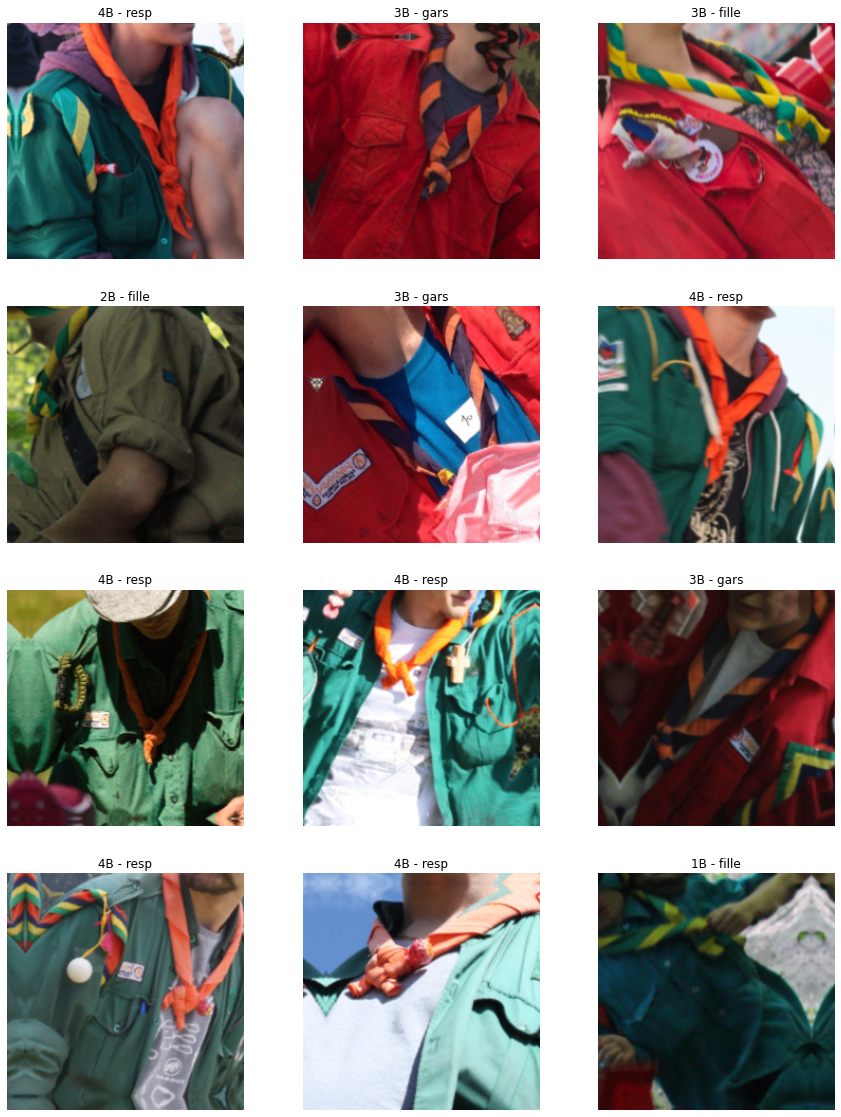

In [11]:
plt.figure(figsize=(15, 20))

i = 0
for _, rowdata in df_train.sample(frac=1).head(12).iterrows():
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(augment_images([open_image(rowdata.path)])[0])
    plt.title(f'{rowdata.unit} - {rowdata.type}')
    plt.axis("off")
    i += 1

## Define model

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)
keras.backend.clear_session()

def get_basic_model(input_layer, name, layers=None):
    input_layer._name = name + "_input"
    layer = input_layer

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
    ]

    if layers == None:
      for l in added_layers:
        layer = l(layer)
    else:
      for l in layers:
        layer = l(layer)

    return Model(inputs=input_layer, outputs=layer, name=name)

def get_model(classes, final_activation, multiple_outputs=False, labels=None, custom_layers=None):
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    base_model.trainable = False

    out_layers = []
    if multiple_outputs:
      if labels == None:
        outputs_labels = [f"out_{i}" for i in range(len(classes))]
        model_labels = [f"model_{i}" for i in range(len(classes))]
      else:
        outputs_labels = [labels[i] for i in range(len(classes))]
        model_labels = [f"branch_{labels[i]}" for i in range(len(classes))]

      for i in range(len(classes)):
        inner_model = get_basic_model(input_layer=base_model.output, name=model_labels[i], layers=(custom_layers[i] if custom_layers != None else None))
        l = inner_model(base_model.output)
        out_layers.append(Dense(classes[i], activation=final_activation, name=outputs_labels[i])(l))

    else:
      inner_model = get_basic_model(input_layer=base_model.output, layers=custom_layers)
      l = inner_model(base_model.output)
      out_layers = Dense(classes, activation=final_activation, name="output")(l)

    model = Model(inputs=base_model.input, outputs=out_layers)
    
    model.compile(
      optimizer = Adam(),
      loss = CategoricalCrossentropy(),
      metrics = ['accuracy']
    )
        
    return model

In [13]:
# keras.backend.clear_session()
# m = get_model([UNIT_CLASSES, TYPE_CLASSES], final_activation="softmax", multiple_outputs=True, labels=["unit", "type"])
# keras.utils.plot_model(model=m, to_file=f"{DRIVE_PREFIX}/model.png", show_shapes=True, expand_nested=True, show_layer_activations=True, layer_range=["out_relu", "type"])

# Model training

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

df_train_paths = df_train['path']
# df_train_labels = np.c_[unit_encoder.transform(df_train['unit']), type_encoder.transform(df_train['type'])]
df_train_labels = mlb.transform(np.c_[df_train['unit'].to_numpy(), df_train['type'].to_numpy()])

print(f"Open {len(df_train_paths)} images")
total_images = open_images(df_train_paths)

Open 140 images


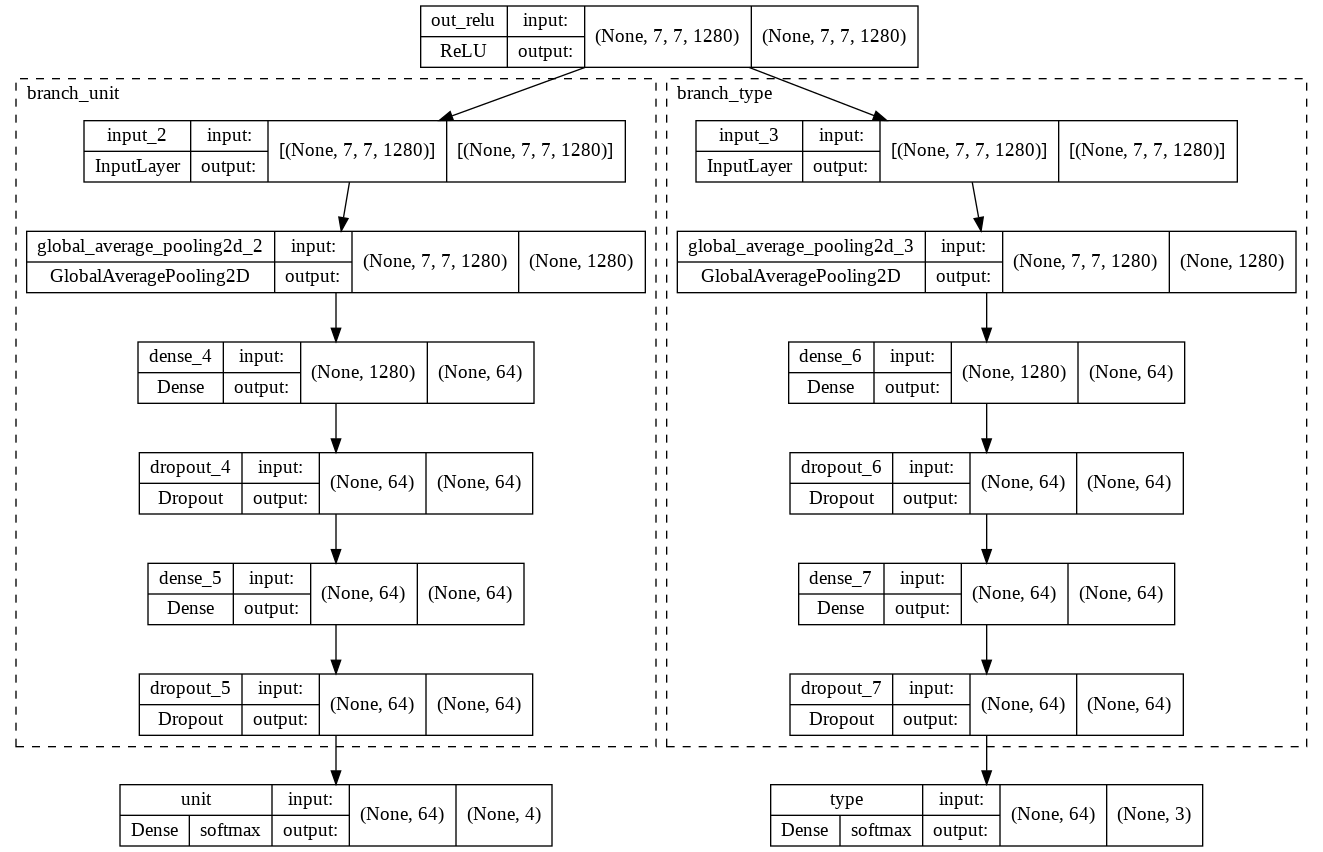

In [44]:
unit_layers = [
    GlobalAveragePooling2D(), 
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),       
]

type_layers = [
    GlobalAveragePooling2D(), 
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),             
]

custom_layers = []
custom_layers.append(unit_layers)
custom_layers.append(type_layers)

keras.backend.clear_session()
m = get_model([UNIT_CLASSES, TYPE_CLASSES], final_activation="softmax", multiple_outputs=True, labels=["unit", "type"], custom_layers=custom_layers)
keras.utils.plot_model(model=m, to_file=f"{DRIVE_PREFIX}/model.png", show_shapes=True, expand_nested=True, show_layer_activations=True, layer_range=["out_relu", "type"])

In [45]:
NB_EPOCHS = 15
AUGMENTATION_RATE = 15
K = 5

train_losses = []
train_losses_unit = []
train_losses_type = []
train_accuracies_unit = []
train_accuracies_type = []
val_losses = []
val_losses_unit = []
val_losses_type = []
val_accuracies_unit = []
val_accuracies_type = []

for train_index, val_index in KFold(n_splits=K, shuffle=True).split(df_train_paths, df_train_labels):
    train_images = total_images[train_index]
    train_labels = df_train_labels[train_index]
    
    val_images = total_images[val_index]
    val_labels = df_train_labels[val_index]
    
    print(f"- Augment {len(train_images)} images to {len(train_images) * AUGMENTATION_RATE}")
    augmented_images, augmented_labels = augment_batch_images(train_images, train_labels, AUGMENTATION_RATE)
    print(f"- Reset model with {len(augmented_images)} train images and {len(val_images)} validation images")
    model = get_model(classes=[UNIT_CLASSES, TYPE_CLASSES], final_activation="softmax", multiple_outputs=True, labels=["unit", "type"], custom_layers=custom_layers) # We reinitialize the model with multiple output layers

    
    history = model.fit(
        x=augmented_images,
        y=[augmented_labels[:,:UNIT_CLASSES], augmented_labels[:,UNIT_CLASSES:]],
        batch_size=32,
        validation_data=[val_images, [val_labels[:,:UNIT_CLASSES], val_labels[:,UNIT_CLASSES:]]],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    train_losses_unit.append(history.history['unit_loss'])
    train_losses_type.append(history.history['type_loss'])
    val_losses.append(history.history['val_loss'])
    val_losses_unit.append(history.history['val_unit_loss'])
    val_losses_type.append(history.history['val_type_loss'])
    train_accuracies_unit.append(history.history['unit_accuracy'])
    train_accuracies_type.append(history.history['type_accuracy'])
    val_accuracies_unit.append(history.history['val_unit_accuracy'])
    val_accuracies_type.append(history.history['val_type_accuracy'])

- Augment 112 images to 1680
- Reset model with 1680 train images and 28 validation images
Epoch 1/15
53/53 [==============================] - 54s 947ms/step - loss: 1.7420 - unit_loss: 0.8902 - type_loss: 0.8517 - unit_accuracy: 0.6327 - type_accuracy: 0.5899 - val_loss: 1.8486 - val_unit_loss: 0.9898 - val_type_loss: 0.8588 - val_unit_accuracy: 0.6071 - val_type_accuracy: 0.6071
Epoch 2/15
53/53 [==============================] - 40s 764ms/step - loss: 0.6668 - unit_loss: 0.2805 - type_loss: 0.3864 - unit_accuracy: 0.9113 - type_accuracy: 0.8470 - val_loss: 1.5467 - val_unit_loss: 0.8349 - val_type_loss: 0.7118 - val_unit_accuracy: 0.6786 - val_type_accuracy: 0.7143
Epoch 3/15
53/53 [==============================] - 41s 771ms/step - loss: 0.3503 - unit_loss: 0.1425 - type_loss: 0.2078 - unit_accuracy: 0.9595 - type_accuracy: 0.9321 - val_loss: 1.7557 - val_unit_loss: 0.8088 - val_type_loss: 0.9469 - val_unit_accuracy: 0.7500 - val_type_accuracy: 0.7143
Epoch 4/15
53/53 [============

KeyboardInterrupt: ignored

# Results

In [ ]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    ax.legend()
    ax.grid()

In [ ]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(5, 1, constrained_layout=True, figsize=(12,15))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_losses_unit, val_losses_unit, "Unit Loss")
plot_kfold_mean_performance(axs[2], train_losses_type, val_losses_type, "Type Loss")
plot_kfold_mean_performance(axs[3], train_accuracies_unit, val_accuracies_unit, "Unit Accuracy")
plot_kfold_mean_performance(axs[4], train_accuracies_type, val_accuracies_type, "Type Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [ ]:
# First retrain model on all the training data
print(f'Opening {len(df_train_paths)} images and augmenting to {len(df_train_paths) * AUGMENTATION_RATE} images')
train_images = open_images(df_train_paths)    
train_labels = df_train_labels

keras.backend.clear_session()
model = get_model(classes=[UNIT_CLASSES, TYPE_CLASSES], final_activation="softmax", multiple_outputs=True, labels=["unit", "type"], custom_layers=custom_layers) # We reinitialize the model

augmented_images, augmented_labels = augment_batch_images(train_images, train_labels, AUGMENTATION_RATE)

history = model.fit(
    x=augmented_images,
    y=[augmented_labels[:,:UNIT_CLASSES], augmented_labels[:,UNIT_CLASSES:]],
    batch_size=32,
    epochs=NB_EPOCHS,
)

In [ ]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

In [ ]:
def print_confusion_matrix(confusion_matrix, title, class_names):
    confusion_matrix_display = me.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=class_names,
    )

    confusion_matrix_display.plot(xticks_rotation='vertical')
    plt.title(title)
    plt.show()

In [ ]:
import sklearn.metrics as me

test_images = open_images(df_test['path'])
test_labels_unit = unit_encoder.transform(df_test['unit'])
test_labels_type = type_encoder.transform(df_test['type'])

pred = model.predict(test_images)
unit_pred = pred[0]
type_pred = pred[1]
unit_pred = np.argmax(unit_pred, axis=-1)
type_pred = np.argmax(type_pred, axis=-1)

In [ ]:
unit_confusion_matrix = me.confusion_matrix(test_labels_unit, unit_pred, labels=np.arange(UNIT_CLASSES))
type_confusion_matrix = me.confusion_matrix(test_labels_type, type_pred, labels=np.arange(TYPE_CLASSES))

print_confusion_matrix(unit_confusion_matrix, "Unit Confusion Matrix", unit_encoder.classes_)
print_confusion_matrix(type_confusion_matrix, "Type Confusion Matrix", type_encoder.classes_)

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

# fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))
def plot_gradcam_plus_plus(labels, classes, col):
    fig, axs = plt.subplots(nb_images_per_class, labels, figsize=(labels * 5, nb_images_per_class * 5))


    for label_idx, label_name in enumerate(classes):
        axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
        
        i = 0
        for _, rowdata in df_train[df_train[col] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
            img = open_image(rowdata.path)    
            pred = model(np.expand_dims(img, axis=0))

            # Generate cam with GradCAM++
            score_unit = CategoricalScore(np.argmax(pred[0]))
            score_type = CategoricalScore(np.argmax(pred[1]))
            cam = gradcam([score_unit, score_type], img)
            heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

            axs[i,label_idx].imshow(img, vmin=0, vmax=1)
            axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
            axs[i,label_idx].axis("off")

            i += 1

        plt.title(f"GradCAM++ for {col} classification")

In [ ]:
plot_gradcam_plus_plus(UNIT_CLASSES, unit_encoder.classes_, 'unit')

In [ ]:
plot_gradcam_plus_plus(TYPE_CLASSES, type_encoder.classes_, 'type')

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it

## Export model to file

In [ ]:
import tensorflow as tf
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

# Task Library expects label files that are in the same format as the one below.
LABEL_FILE = DRIVE_PREFIX + "/exported-model/labels.txt"
SAVE_TO_PATH = DRIVE_PREFIX + "/exported-model/MyModel.tflite"

# Create the labels file
with open(LABEL_FILE, 'w') as label_file:
    for label in mlb.classes_: # /!\ class_names variable must contains the names of the labels you have.
        label_file.write("{}\n".format(label))

tflite_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()

# Save the model.
with open(SAVE_TO_PATH, 'wb') as f:
    f.write(tflite_model)
    
ImageClassifierWriter = image_classifier.MetadataWriter

# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
INPUT_NORM_MEAN = 127.5
INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(SAVE_TO_PATH),
    [INPUT_NORM_MEAN],
    [INPUT_NORM_STD],
    [LABEL_FILE, LABEL_FILE]
)

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
# writer_utils.save_file(writer.populate(), SAVE_TO_PATH) /!\ Doesn't work with multiple outputs